# Truth level info in the B-tagging N-tuple#

Nicole Hartman
Summer 2017


The Ntuple I'm looking at is from tt decay, and Michael said that the typical energies of the b-hadrons in this sample are around 20 - 100 GeV (but sometimes larger, I'm going to plot that momentarily.)

In [1]:
filepath  = '/atlas/local/BtagOptimizationNtuples/user.giacinto.mc16_13TeV.410501.PowhegPythia8EvtGen_A14_ttbar_hdamp258p75.BTagNtuples.May22.JetFitterStudies.v02_Akt4EMTo/user.giacinto.11401650.Akt4EMTo._000001.root'

In [2]:
import numpy as np
import pandas as pd

# matplotlib includes
import matplotlib.pyplot as plt
import matplotlib.cm as cm # color map palatte
from matplotlib.colors import LogNorm

# rootpy functions
from rootpy.vector import LorentzVector,Vector3
from rootpy.plotting import Hist,Hist2D
import rootpy.plotting.root2matplotlib as rplt

# useful functions that I've used in different notebooks stored in a single module
from dataHandling import root2pandas, flatten, flatten_trks

In [3]:
df = root2pandas(filepath, 'bTag_AntiKt4EMTopoJets')

First plot the number of tracks associated to the B and D hadrons in the decay chain.

Note: the number of tracks from the B don't include those from the D later in the decay chain. 

Also, the truth level info only stores info about the charged children.

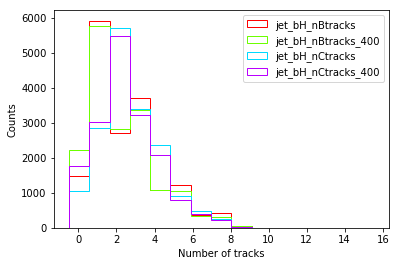

In [4]:
# The leaf jet_bH_nBtracks doesn't store the tracks from the subsequent D-decay, these
# tracks are stored inside jet_bH_nCtracks

ntrk_df = df[[key for key in df.keys() if (key.startswith('jet_bH_n'))]]
ntrk_df_flat = pd.DataFrame({k: flatten_trks(c) for k, c in ntrk_df.iteritems()})

bins = np.linspace( -0.5, 15.5, 16) 

# select your favorite matplotlib color palette
color = iter(cm.hsv(np.linspace(0, 0.8, 4)))

for key in ntrk_df_flat.keys(): # plot the various variables one by one on different graphs

    c = next(color)
    _ = plt.hist(ntrk_df_flat[key][ntrk_df_flat[key]!= -99], 
                    bins=bins, histtype='step', label=key, color=c)
                    #,normed=True)
        
# prettify your histograms
plt.xlabel('Number of tracks')
plt.ylabel('Counts')
plt.legend()
plt.show()

The Bs (w/o Ds incorporated) in general have a fewer tracks than the Ds.

Most of the tracks of interest are higher pT than 400 MeV, which is the lowest momenta tracks that we can measure in the tracker.

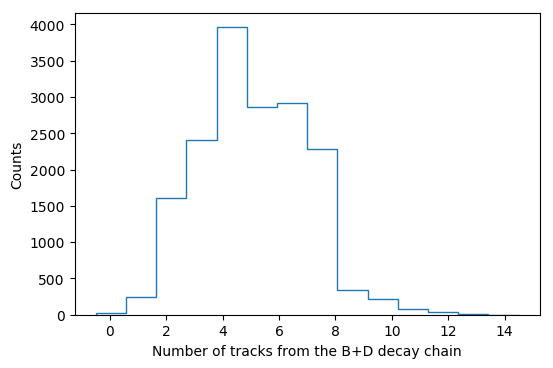

Mean # of trks from B decay-chain: 4.82707695928
Mean # of trks from D from the B:  2.54542245234


In [5]:
# Plot the # of tracks from the B inclusive with the number of tracks from the D
# and calcuate the mean (should be 5).

nBtrks_inclusive = [trksB+trksD for trksB,trksD in zip(ntrk_df_flat['jet_bH_nBtracks'][ntrk_df_flat['jet_bH_nBtracks']!=-99],ntrk_df_flat['jet_bH_nCtracks'][ntrk_df_flat['jet_bH_nCtracks']!=-99])]
# ^ This list will also include some -99s and -98s, but we'll just ignore those for now.

# set up your figures
fig = plt.figure(figsize=(6, 4), dpi=100)
# specify ranges and binning strategies that make sense
bins = np.linspace(
    min(nBtrks_inclusive)-0.5, # min
    max(nBtrks_inclusive)+0.5, # max
    1+max(nBtrks_inclusive)-min(nBtrks_inclusive) # number of bins
    )

_ = plt.hist(nBtrks_inclusive, bins=bins, histtype='step')
           
# prettify your histograms
plt.xlabel('Number of tracks from the B+D decay chain')
plt.ylabel('Counts')
plt.show()

print "Mean # of trks from B decay-chain: {}".format(np.mean(nBtrks_inclusive))
print "Mean # of trks from D from the B:  {}".format(np.mean(ntrk_df_flat['jet_bH_nCtracks'][ntrk_df_flat['jet_bH_nCtracks']!=-99]))

Next: Look at how the number of tracks from the C and B hadrons in the b-cascade are correlated with each other. 

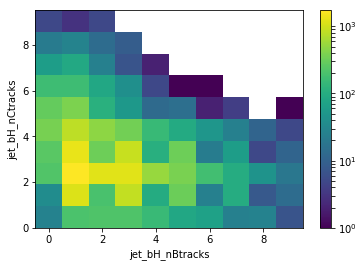

In [6]:
plt.hist2d(ntrk_df_flat['jet_bH_nBtracks'],ntrk_df_flat['jet_bH_nCtracks'],bins=10,range=[[-0.5,9.5], [0, 9.5]],norm=LogNorm())
plt.colorbar()
plt.xlabel('jet_bH_nBtracks')
plt.ylabel('jet_bH_nCtracks')
plt.show()

There seems to be a slight negative correlation between the number of b and c tracks, which helps make the number of total tracks from the B+D cascade peaked around 5. 

# Apply the vtx correction at the truth level

Note: We don't have to worry about the errors on the vtx position b/c we know the momenta of the b-hadron flight direction exactly. Also, we know the children masses, instead of using the mass of pions for all the children.

In [7]:
'''
Plot a 1d hist using rootpy.plotting

If a legend is also passed in, this function will expect a list of hists
to plot and label w/ the associated legends.
'''
def plot_1D(hist, title="",xlabel="", ylabel="",logy=False,legend=None,norm=False):

    # Possible extenstion:
    # Could also use a color map to support more color options
    colors = ['r','b','g','m','c','k']
    
    fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
    if logy:
        ax = plt.subplot(111)
        ax.set_yscale("log")
        ax.set_ylim(ymin=1)

            
    # If there's a legend plot the histograms in the list
    if legend:
        for myHist, legEntry, c in zip(hist,legend,colors):
            # Normalize the histogram if this option was requested
            if norm:
                myHist = myHist / myHist.GetEntries()
            # Plot the histogram
            rplt.hist(myHist,label=legEntry,color=c)
            
        plt.legend()   
        
    # Otherwise just plot the one hist that was passed in
    else:
        if norm:
                hist = hist / hist.GetEntries()
        rplt.hist(hist)
    
    # Add labels and legends
    plt.xlabel(xlabel)
    plt.ylabel('Events')
    plt.title(title)
    plt.show()
      

In [8]:
'''
Plot a 2d dist using rootpy.plotting

I'm not sure if I need to make this more complicated...
'''
def plot_2D(hist, title="", xlabel="", ylabel=""):
    fig = plt.figure(figsize=(6, 4), dpi=100, facecolor='white')
    #ax = plt.subplots(111)
    rplt.hist2d(hist,norm=LogNorm())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    im = rplt.imshow(hist)
    fig.colorbar(im)
    plt.show()    

In [9]:
'''
Look at the best that we can do with the corrected mass formula by looking at the truth charged children
for the B and C-hadron stored by jet fitter

Inputs:
     isB:   True to look at the B vtx mass
            False for the C vtx mass
            
     nevts: The number of events to iterate over in filling the histograms
            The default value of -1 will run over all of the evts in the ntuple.
     
Outputs:
     Plots the m from the sum of the charged tracks and the m due to the corrected formula, 
     and the pT of the charged tracks w/r.t. the bH momentum vector.

'''
def plotTruthVertexMass(isB=True,nevts=-1):

    nbins_1d = 40
    nbins_2d = 20
    
    # 1D Mass histograms
    mass_ch   = Hist(nbins_1d, 0, 10)
    mass_corr = Hist(nbins_1d, 0, 10)
    mass_cut1 = Hist(nbins_1d, 0, 10)
    mass_cut2 = Hist(nbins_1d, 0, 10)
    
    # Looking at the mass pt, and and correction dependancies
    Mch_vs_Pt = Hist2D(nbins_2d,0,6,nbins_2d,0,6)
    dM_vs_Mch = Hist2D(nbins_2d,0,6,nbins_2d,0,6)
    
    # Probing our understanding of the system
    Ptch_vs_Ptb   = Hist2D(nbins_2d,0,125,nbins_2d,0,2)
    dRtrks_vs_Ptb = Hist2D(nbins_2d,0,125,nbins_2d,0,0.4)
    
    pt_ch     = Hist(40,0,10)

    pi = LorentzVector() # Stores the LorentzVector for the i^{th} track
    r  = Vector3()       # Stores the 3-vector for the bh flight dir

    # Check if you should be looking at a b of c hadron
    if isB:
        df['jet_bH_nB+Ctracks'] = df['jet_bH_nBtracks'] + df['jet_bH_nCtracks']
        my_df = df[['jet_bH_pt','jet_bH_eta','jet_bH_phi','jet_bH_nB+Ctracks','jet_bH_child_px','jet_bH_child_py','jet_bH_child_pz','jet_bH_child_E']]
    else:
        my_df = df[['jet_cH_pt','jet_cH_eta','jet_cH_phi','jet_cH_nCtracks','jet_cH_child_px','jet_cH_child_py','jet_cH_child_pz','jet_cH_child_E']]
 
    # Determine whether you should just run over a subset of events
    if nevts >= 0:
        my_df = my_df[:nevts]
        print "This hadron has {0} tracks, but the length of the child vector is {1}".format(bH_ntrk[0],trk_pxs[:bH_ntrk])
    

    for (_,(bH_pts,bH_etas,bH_phis,bH_ntrks,evt_trk_px,evt_trk_py,evt_trk_pz,evt_trk_E)) in my_df.iterrows():
    
        for bH_pt,bH_eta,bH_phi,bH_ntrk,trk_pxs,trk_pys,trk_pzs,trk_Es in zip(bH_pts,bH_etas,bH_phis,bH_ntrks,evt_trk_px,evt_trk_py,evt_trk_pz,evt_trk_E):

            if bH_pt[0] == -99:
                continue
        
            # Print out when the number of tracks is different than the # of children
            if(bH_ntrk[0] != len(trk_pxs[:bH_ntrk[0]]) ):
                print "This hadron has {0} tracks, but the length of the child vector is {1}".format(bH_ntrk[0],len(len(trk_pxs[:bH_ntrk[0]]) ))
        
            p = LorentzVector(0,0,0,0)
            r.SetPtEtaPhi(bH_pt[0],bH_eta[0],bH_phi[0])
            dR = 0
        
            for trk_px,trk_py,trk_pz,trk_E in zip(trk_pxs[:bH_ntrk[0]],trk_pys[:bH_ntrk[0]],trk_pzs[:bH_ntrk[0]],trk_Es[:bH_ntrk[0]]):
                pi.SetPxPyPzE(trk_px,trk_py,trk_pz,trk_E)
                p = p + pi
                dR = dR + r.DeltaR(pi.Vect())
            
            pt_flightDir = (p.Vect()).Perp(r) / 1000.
            m = p.M()/1000.
            m_corr = np.sqrt(m*m + pt_flightDir*pt_flightDir) + np.abs(pt_flightDir) 
            m_cut1 = m_corr if m_corr < 2*m else m
            m_cut2 = m_corr if pt_flightDir <= m else m
            Pt_bH = r.Pt()/1000.
            dR = dR if bH_ntrk[0] == 0 else dR / bH_ntrk[0]

            pt_ch.Fill(pt_flightDir)
            mass_ch.Fill(m)
            mass_corr.Fill(m_corr)
            mass_cut1.Fill(m_cut1)
            mass_cut2.Fill(m_cut2)
            Mch_vs_Pt.Fill(pt_flightDir,m)
            dM_vs_Mch.Fill(m,m_corr-m)

            Ptch_vs_Ptb.Fill(Pt_bH , pt_flightDir)
            dRtrks_vs_Ptb.Fill(Pt_bH , dR )
                    
    hadron = "B" if isB else "C"
    
    # Plot the histograms
    hists = [mass_ch, mass_corr, mass_cut1, mass_cut2]
    legend = ['$M_{ch}$','$M = \sqrt{M_{ch}^2 + p_\perp^2} + |p_\perp|$','$M < 2 M_{ch}$','$p_\perp < M_{ch}$']
    title = 'Correcting for the {0} mass at the truth level'.format("B" if isB else "C")
    vtx_xlabel  = '{} vtx mass [GeV]'.format(hadron)
    pT_h_xlabel = "$p_T({}-hadron)$".format(hadron)
    
    plot_1D(hists,title=title,xlabel=vtx_xlabel,ylabel='Events',legend=legend) 
    plot_1D(hists,title="",   xlabel=vtx_xlabel,ylabel='Events',legend=legend,logy=True) 
    plot_1D(pt_ch,xlabel="$p_\perp$ of chgd trks [GeV]",ylabel="Events")
    plot_2D(Mch_vs_Pt,title="{} truth".format("B" if isB else "C"),xlabel="$p_\perp$ of charged tracks",ylabel="$M_{ch}$")
    plot_2D(dM_vs_Mch,title="{} truth".format("B" if isB else "C"),xlabel="$M_{ch}$",ylabel="$\Delta M = M - M_{ch}$")
    plot_2D(Ptch_vs_Ptb,  xlabel=pT_h_xlabel,ylabel="$p_\perp$ of trks w/r.t. {}".format(hadron))
    plot_2D(dRtrks_vs_Ptb,xlabel=pT_h_xlabel,ylabel="$Avg \Delta R(trk,{}-hadron)$".format(hadron))
    
    print "Mean p perp of the trks: {0:1.2f} GeV".format(pt_ch.GetMean())
    print "Underflow bin in the m_ch histogram: {}".format(mass_ch.GetBinContent(0))
    print "Number of entries: {}".format(mass_corr.GetEntries())

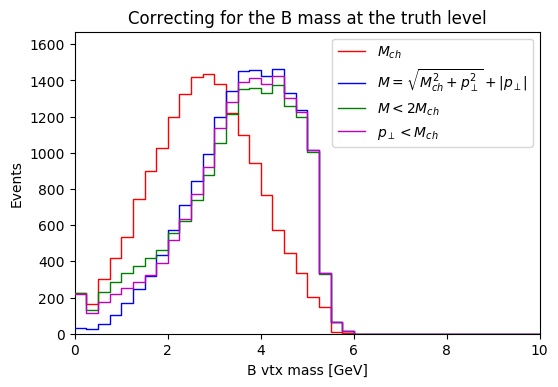

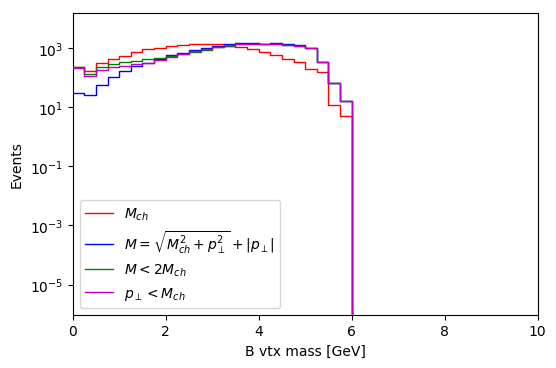

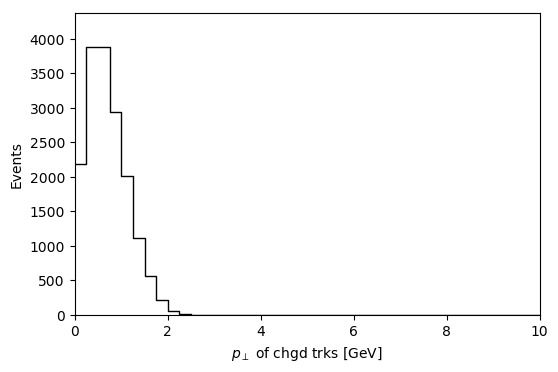

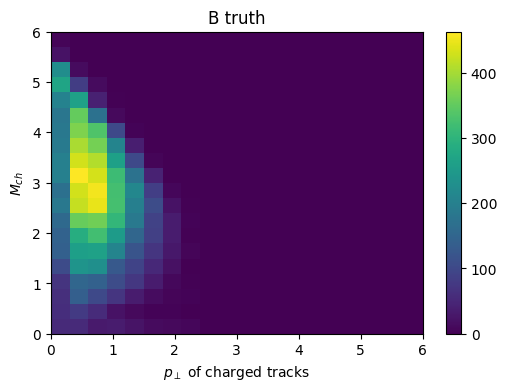

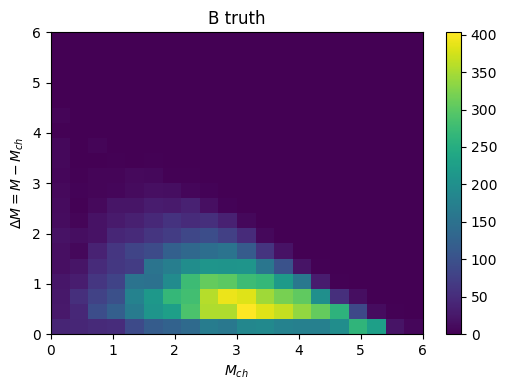

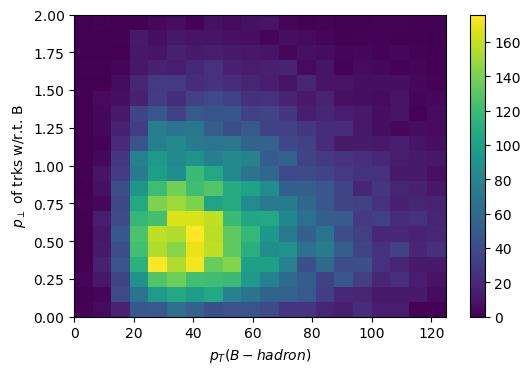

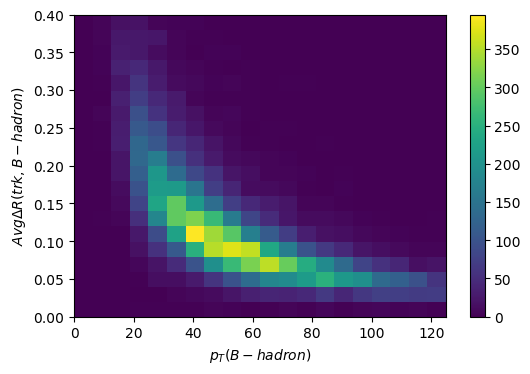

Mean p perp of the trks: 0.71 GeV
Underflow bin in the m_ch histogram: 27.0
Number of entries: 16848.0


In [10]:
plotTruthVertexMass(isB=True)

- Requiring $M = \sqrt{M_{ch}^2 + p_\perp} < 2*M_{ch}$ is a tighter cut than requiring $M_{ch} < p_\perp$ because since $M < M_{ch} + p_\perp$, the first cut says $M < 2M_{ch}$, which will be guaranteed if $M_{ch} < p_\perp$. This in confirmed in these plots from the fact that the $p_\perp < M_{ch}$ curve is closer to the uncorrected curve than the $M < 2*M_{ch}$ one is.

- In the logarithmic plot, it also doesn't seem that these additional cuts on whether we accept the mass of the bH are having an affect on the tails of these neutrals, mainly because the pT of these charged particles is so much less than the mass of the B to be impacted by these cuts.

- I think something else that is intesting from these plots is the spike when $M_{ch}$ is exactly 5, because in case, no neutrals were produced to screw up the M calculation, so the pT of the charged particles is 0, so the $M_{ch}$ is in fact the mass of the b-hadron (since we're at truth level). This shows up in the second 2D distribution as a correction of 0.

- The $p_\perp$ of the charged particles doesn't depend on the $p_T$ of the b-hadron because $p_\perp$ is invariant to the boost of the b-hadron

- There's a beautiful dR = 2m / pT dependence for the opening angle of the decay products.

Note on the underflow: According to the TLorentzVector documentation, root will return a negative value for M() if $M^2 = E^2 - P^2 < 0$.

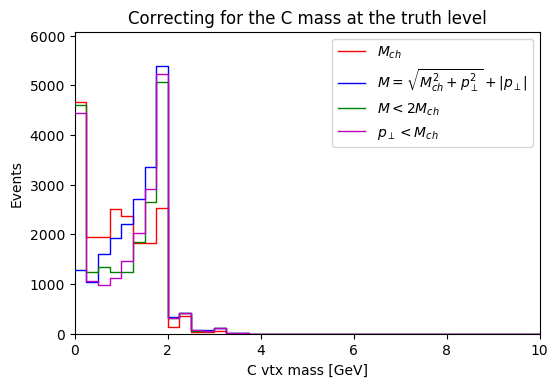

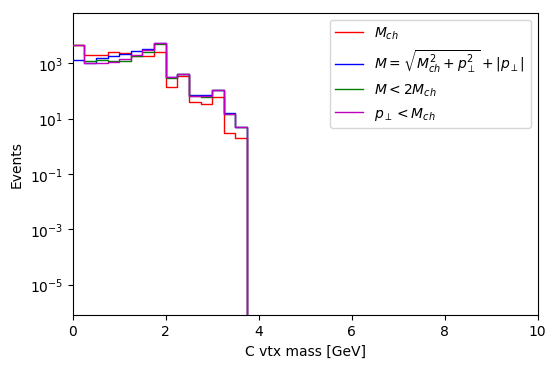

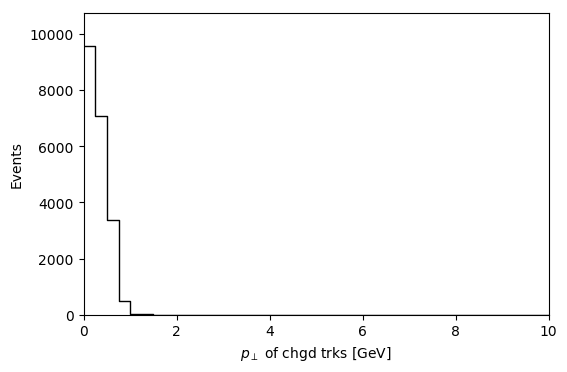

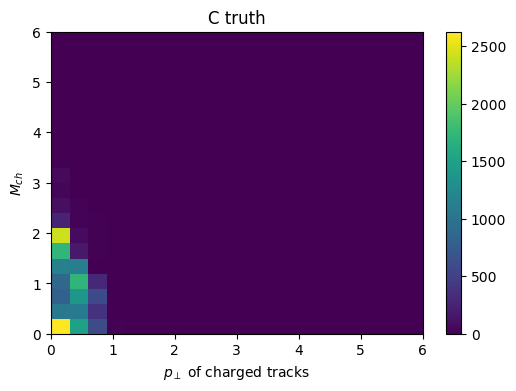

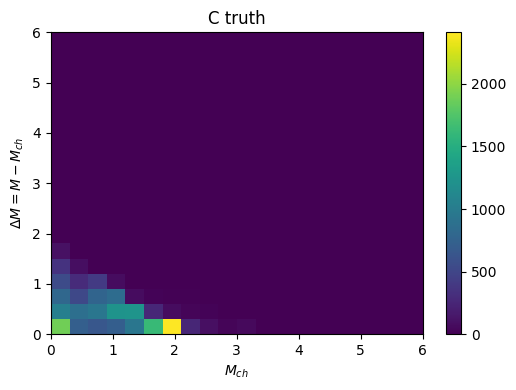

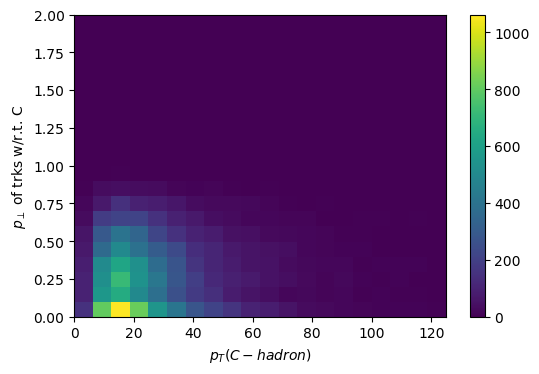

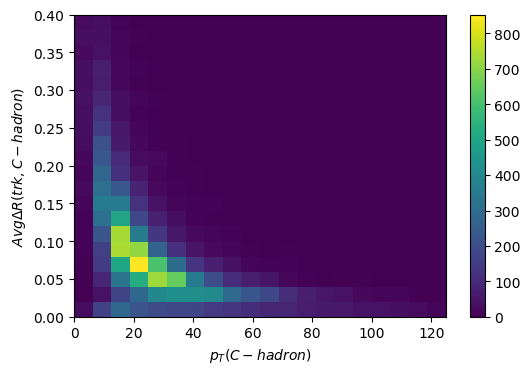

Mean p perp of the trks: 0.29 GeV
Underflow bin in the m_ch histogram: 294.0
Number of entries: 20547.0


In [11]:
plotTruthVertexMass(isB=False)

- The pT distribution of the pT of the charm tracks is to be a little softer, yielding a smaller correction than we saw in the b distribution. It also seems like the cuts are pulling up back the distribution of the charms back more than the bs were, because since the charm mass is smaller, this corrected mass is more likely to be impacted by the cuts.

- From the log plot, it seems like the corrected mass formulas are yielding an increase in the tails of the distributions of the charms, although the tails with the cuts might be slightly smaller, although I can't tell if it's statistically significant.

- In the charm distributions, there's a significant amount of time that the pT is zero, and no correction is applied (it appears to be more frequent than it was w/ the Bs)

- In the avg(dR) vs. pT(hadron) plot, it looks like the tracks from the charm are more closely aligned w/ the c-hadron, which is probably due to the fact that the charm mass is smaller, but I think this is also interesting b/c the charms were also softer than the bs. 

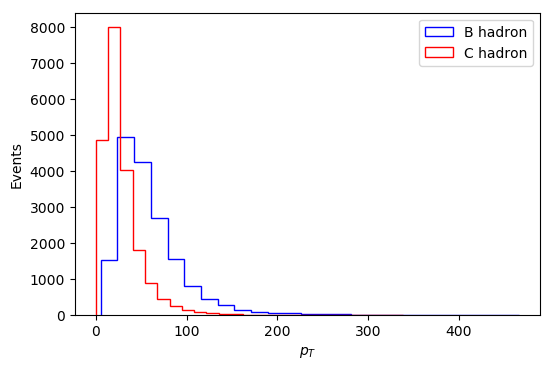

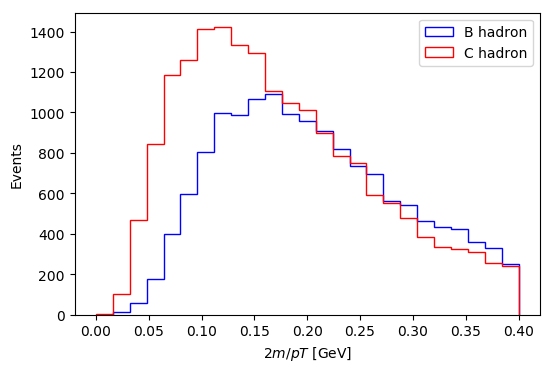

In [12]:
pT_bH = np.array([0.001*x[0] for x in flatten(df['jet_bH_pt']) if x[0] != -99])
pT_cH = np.array([0.001*x[0] for x in flatten(df['jet_cH_pt']) if x[0] != -99]) 

fig = plt.figure(figsize=(6, 4), dpi=100)
plt.hist(pT_bH, bins=25, histtype='step',label='B hadron',color='b')
plt.hist(pT_cH, bins=25, histtype='step',label='C hadron',color='r')
plt.xlabel('$p_T$')
plt.ylabel('Events')
plt.legend()
plt.show()

m_bH = 5.3 # in GeV
m_cH = 1.9

fig = plt.figure(figsize=(6, 4), dpi=100)
plt.hist(2*m_bH/pT_bH, bins=25, range=(0,0.4), histtype='step',label='B hadron',color='b')
plt.hist(2*m_cH/pT_cH, bins=25, range=(0,0.4), histtype='step',label='C hadron',color='r')
plt.xlabel('$2m / pT$ [GeV]')
plt.ylabel('Events')
plt.legend()
plt.show()


As expected, the smaller mass of the charm contributes to the smaller opening angle of its decay products.